<a href="https://colab.research.google.com/github/doeungim/ADP_DE/blob/main/ADP_Exam1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import os
os.getcwd()

from IPython.display import display,HTML
display(HTML('<style>.Container {width : 95% !important:}</style>'))

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

import platform
if platform.system() == 'Windows':
    path = 'c:/Windows/Fonts/malgun.ttf'
    font_name = font_manager.FontProperties(fname=path).get_name()
    plt.style.use('seaborn-darkgrid')
    rc('font', family=font_name)

In [2]:
df =pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/mock/001_m1.csv')
df.head()


,user_id,timestamp,event,params,age,gender
0,668300627f964509a7f5b5f63b570d55,2024-02-18,first_visit,{'source': 'sns'},31,M
1,668300627f964509a7f5b5f63b570d55,2024-03-04,visit,NaN,31,M
2,668300627f964509a7f5b5f63b570d55,2024-03-16,visit,NaN,31,M
3,668300627f964509a7f5b5f63b570d55,2024-03-30,visit,NaN,31,M
4,668300627f964509a7f5b5f63b570d55,2024-04-26,visit_and_purchase,{'product': 'Clothing'},31,M


In [3]:
df.timestamp = pd.to_datetime(df.timestamp, format = '%Y-%m-%d')

In [4]:
df['params'] = df['params'].fillna('None')
df['param_category1']= df['params'].str.replace(r"[{},',:]", "",regex = True).str.split(' ').str[0]
df['param_category2'] = df['params'].str.replace(r"[{},',:]", "",regex = True).str.split(' ').str[1].fillna('unknown')

df1 = df.drop(columns = 'params')

In [5]:
df1.isnull().sum()
display(df1.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68175 entries, 0 to 68174
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   user_id          68175 non-null  object        
 1   timestamp        68175 non-null  datetime64[ns]
 2   event            68175 non-null  object        
 3   age              68175 non-null  int64         
 4   gender           68175 non-null  object        
 5   param_category1  68175 non-null  object        
 6   param_category2  68175 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 3.6+ MB


None

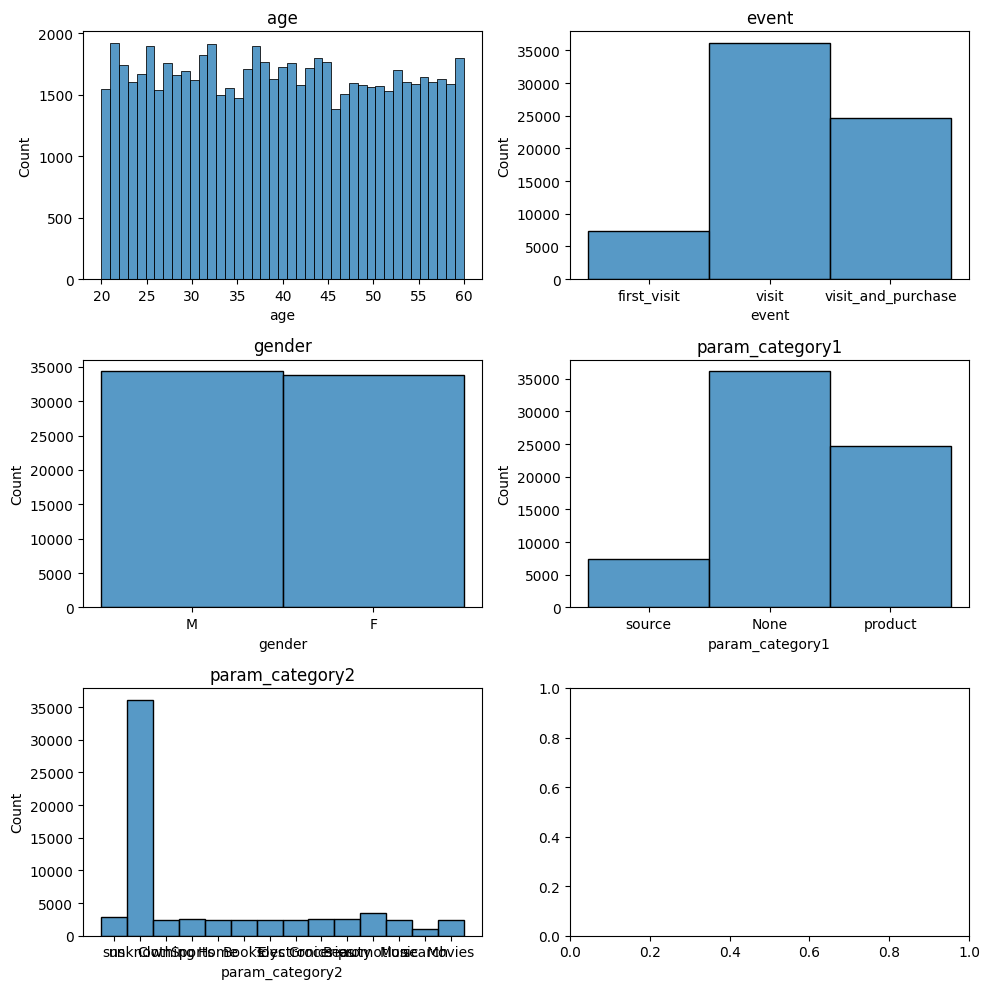

In [6]:
## EDA - timestamp 와 user_id는 생략
cols = list(df1.columns.difference(['timestamp','user_id']))

fig, axes = plt.subplots(3,2 , figsize =  (10,10))
axes = axes.flatten()

counter = 0
for col in cols:
    sns.histplot(df1[col], ax=axes[counter])
    axes[counter].set_title(col)
    counter += 1

plt.tight_layout()
plt.show()





유저의 7일차 31일차 앱 재방문율(리텐션) </br>
리텐션은 최초 앱방문일자를 기준으로 몇일 차 후에 또다시 방문했는지를</br>
전체 유저에 대해 데이터를 구하고 0일차 방문 횟수로 나누어 비율

In [7]:
df2 = df1.copy()
## 1) first_visit 인것만
first_visit = df2[df2['event'] == 'first_visit']
not_first_visit = df2[df2['event'] != 'first_visit']


from datetime import timedelta
# 최초 방문에서 7일, 31일의 날짜를 구하기
first_visit['first_visit_7'] = first_visit['timestamp'] + timedelta(days = 7)
first_visit['first_visit_31'] = first_visit['timestamp'] + timedelta(days = 31)


# 7일차들을 처음 방문이 아닌 것들과 Merge
first_7th = pd.merge(first_visit, not_first_visit,  left_on = ['user_id','first_visit_7'], right_on = ['user_id','timestamp'])
first_31th  = pd.merge(first_visit, not_first_visit, left_on = ['user_id', 'first_visit_31'], right_on = ['user_id', 'timestamp'])

## 7일차 / 첫 번째 구매자 OR 31일차 / 첫번째 구매자
retenstion_7th = (len(first_7th)) / (len(first_visit))
retenstion_31th = (len(first_31th)) / (len(first_visit))

print(f'7일차 리텐션 : {round(retenstion_7th * 100,2)},')
print(f'31일차 리텐션 : {retenstion_31th * 100}')

7일차 리텐션 : 1.99,
31일차 리텐션 : 2.8798277486206434


가입일 포함 첫 31일 동안의 유저 행동을 통해 32일째 부터 7일동안의 물건 구매 여부를 확인하는 모델링을 진행하려고 한다.


* 유저별 가입 후 한달 동안의 메타정보에 대한 테이블 (자율구성)
* 종속 변수 : 가입 후 한달 후 일주일 동안 물건 구매 여부 (0,1)

In [8]:
# 첫 가입만 추출하여 user_id 과 가입 날짜
first = df2[df2.event =='first_visit'][['user_id','timestamp']].rename(columns ={'timestamp':'first'}).reset_index(drop=True)

m = pd.merge(df2[['user_id', 'timestamp']], first)
m['days'] = (m['timestamp'] - m['first']).dt.days


In [9]:
import datetime

dft = pd.merge(df2, m)
dft['first_month'] = dft['first'].dt.month


last_day = pd.to_datetime('2024-12-31') - datetime.timedelta(days = 7 + 31)
dft_first = dft[(dft['first'] <= pd.to_datetime('2024-11-23')) & (dft['days'] <= 37)].reset_index(drop= True)

first_one_month = dft_first[dft_first.days <= 30].reset_index(drop = True)
after_one_month = dft_first[dft_first.days > 30].reset_index(drop = True)

In [10]:
source = dft_first[dft_first.param_category1 != 'None'][['user_id', 'param_category1', 'param_category2', 'age', 'gender','first_month']].reset_index(drop = True)

# 총 구매 횟수
total_purchase = first_one_month.query("event =='visit_and_purchase'").user_id.value_counts().to_frame().reset_index()
display(total_purchase)
# 구매 물품별 구매 횟수 - pivoting
product_purchased = first_one_month[first_one_month.param_category2 !='None'].groupby(['user_id', 'param_category2']).size().unstack().fillna(0).reset_index()


# 방문 횟수
only_visit_counts = first_one_month.query("event == 'visit'").user_id.value_counts().to_frame().reset_index().rename(columns = {'count': 'only_visit_counts'})

,user_id,count
0,ebca159ca3ea46c6984d517786a3cfcc,6
1,c141521cca514cc189ff6f0d06d9db62,6
2,d18a1b5b34f347878f6e0a513ad6b7c8,5
3,903be4a457074ca99d256092505418f6,5
4,1a52f2bce8144bb2b989d633a076a041,5
...,...,...
3365,6f832318cd1e4b21b894236342bd31a6,1
3366,bfa23499954e4f8098e515973a292561,1
3367,2a459089ef4442ca9c112a0a60309fa0,1
3368,d3f124cb880a4cc8bafc5c6d4a57657f,1


In [11]:
## 종속변수 구매 유무
target = after_one_month.groupby(['user_id','event']).size().unstack()['visit_and_purchase'].fillna(0).map(lambda x : 1 if x >=1 else 0 ).to_frame().reset_index().rename(columns = {'visit_and_purchase':'purchase'})


In [12]:
mer1 = pd.merge(source, total_purchase, on ='user_id', how ='outer')
mer2 = pd.merge(mer1, product_purchased, on ='user_id', how ='outer')
mer3 = pd.merge(mer2, only_visit_counts, on ='user_id', how ='outer')
mer4 = pd.merge(mer3, target , on = 'user_id', how = 'outer').fillna(0)
mer4['purchse'] = mer4['purchase'].astype('int')


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2117
         1.0       1.00      1.00      1.00       308

    accuracy                           1.00      2425
   macro avg       1.00      1.00      1.00      2425
weighted avg       1.00      1.00      1.00      2425

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2117
         1.0       1.00      1.00      1.00       308

    accuracy                           1.00      2425
   macro avg       1.00      1.00      1.00      2425
weighted avg       1.00      1.00      1.00      2425

RandomForest : 1.0
DecisionTree : 1.0


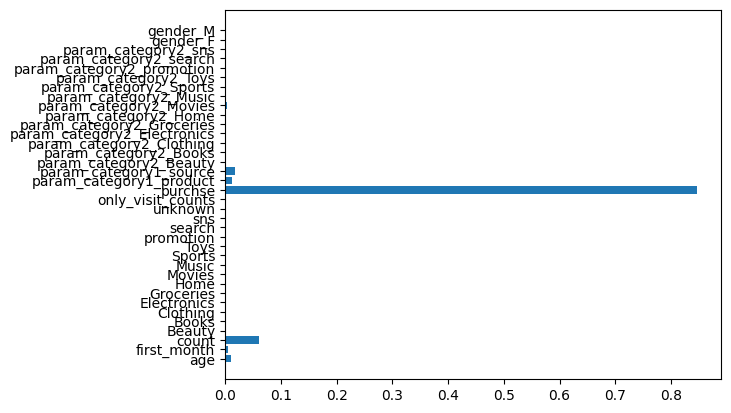

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

x = mer4.drop(columns = ['user_id','purchase'])
y = mer4['purchase']

dummy_x = pd.get_dummies(x)


x_train, x_test, y_train, y_test = train_test_split(dummy_x, y, test_size = 0.2, random_state = 42, stratify= y)
# Modelling
rf = RandomForestClassifier(random_state = 42)
dt = DecisionTreeClassifier(random_state = 42)

rf.fit(x_train, y_train)
dt.fit(dummy_x, y)

rf_pred = rf.predict(x_test)
dt_pred = dt.predict(x_test)

rf_score = accuracy_score(y_test, rf_pred)
dt_score = accuracy_score(y_test, dt_pred)

print(classification_report(y_test, rf_pred))
print(classification_report(y_test, dt_pred))

print(f'RandomForest : {rf_score}')
print(f'DecisionTree : {dt_score}')

plt.barh(x_train.columns , rf.feature_importances_)
plt.show()


In [43]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/mock/001_m2.csv')
df.head()

,TIMESTAMP,bitcoin($)
0,1.577837e+09,7195.24
1,1.577837e+09,7187.67
2,1.577837e+09,7184.41
3,1.577837e+09,7183.83
4,1.577837e+09,7185.54


In [44]:
## 결측 - 보간법
from datetime import datetime

## Timestamp 보간
df['TIMESTAMP'] = df['TIMESTAMP'].interpolate(method = 'linear')
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'], unit = 's')

## bitcon보간 - 다항식 보간법
df['bitcoin($)'] = df['bitcoin($)'].interpolate(method = 'polynomial', order = 2)

In [45]:
df = df.rename(columns = {'bitcoin($)': 'price'})
## SET_INDEX 설정 필요
df

,TIMESTAMP,price
0,2020-01-01 00:00:00,7195.24
1,2020-01-01 00:01:00,7187.67
2,2020-01-01 00:02:00,7184.41
3,2020-01-01 00:03:00,7183.83
4,2020-01-01 00:04:00,7185.54
...,...,...
44995,2020-02-01 05:55:00,9394.20
44996,2020-02-01 05:56:00,9394.18
44997,2020-02-01 05:57:00,9392.01
44998,2020-02-01 05:58:00,9386.00


In [46]:
df = df.rename(columns = {'bitcoin($)': 'price'})

## 정상성 진단 - 통계, 시각적 방법
from statsmodels.tsa.stattools import adfuller

# H0: 단위근이 존재한다 (비정상 시계열)
# H1: 단위근이 존재하지 않는다 (정상 시계열)

adf = adfuller(df, regression = 'c', autolag = 'AIC')
print(adf[0])
print('p_value :', adf[1])

TypeError: float() argument must be a string or a real number, not 'Timestamp'

In [47]:
## 방법 2 ) KPSS
# H0 : 정상이다
# H1 : 정상이 아니다.

from statsmodels.tsa.stattools import kpss
kpss_result = kpss(df)

print(kpss_result[0])
print(kpss_result[1])

TypeError: float() argument must be a string or a real number, not 'Timestamp'

TypeError: float() argument must be a string or a real number, not 'Timestamp'

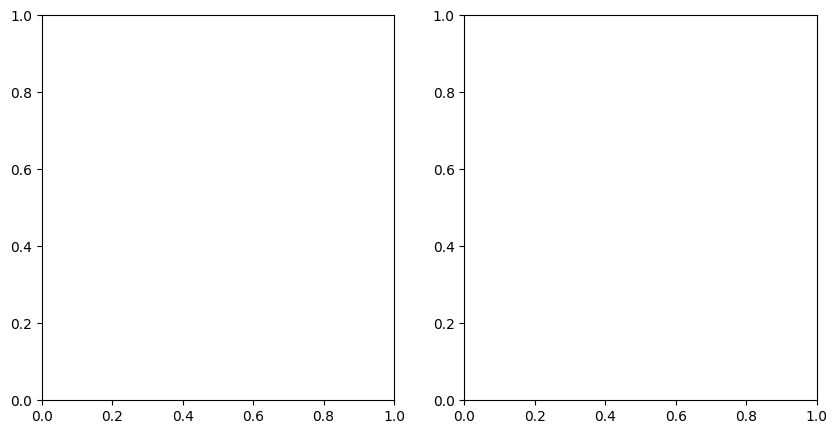

In [48]:
## 방법 3) ACF Plot
import statsmodels.api as sm

fig, ax = plt.subplots(1,2, figsize = (10,5))
sm.graphics.tsa.plot_acf(df.values.squeeze(), lags = 30, ax = ax[0])
sm.graphics.tsa.plot_pacf(df.values.squeeze(), lags = 30, ax = ax[1])

## 정상성 판단 유무 : acf 가 시점에 따라 빠르게 감소하지 않으므로 비정상 시계열

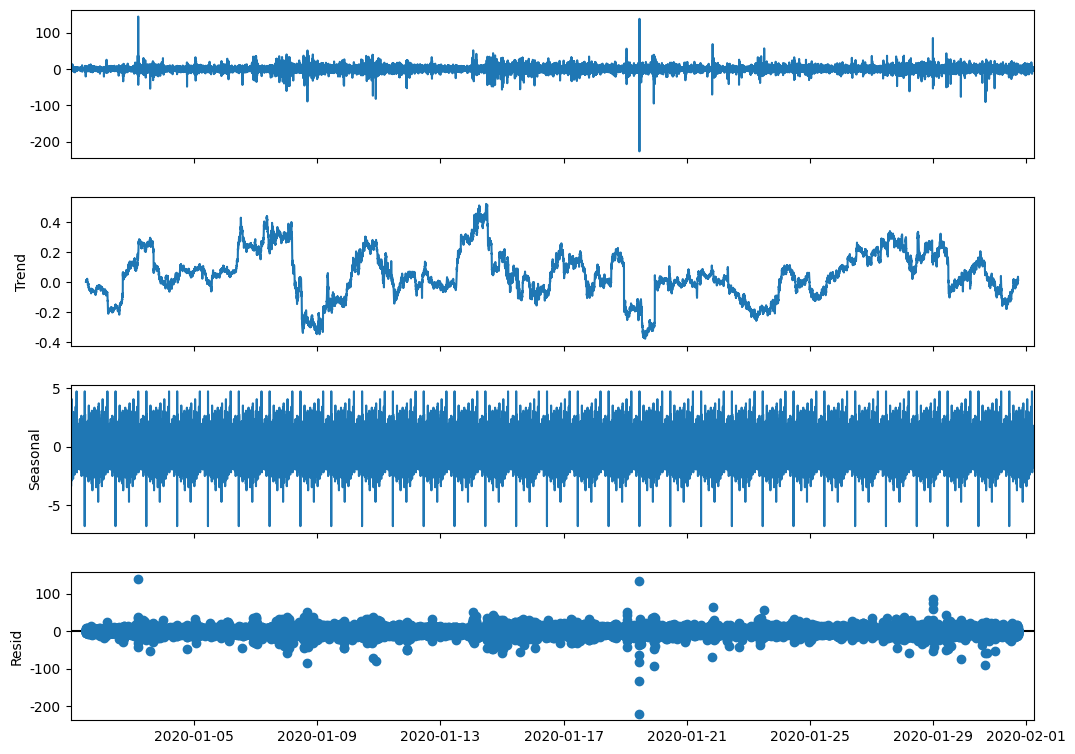

In [54]:
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
w = df.copy()
w['price_diff'] = w['price'].diff(1)

res = seasonal_decompose(w[['TIMESTAMP','price_diff']].set_index('TIMESTAMP').dropna(), model = 'additive', period = 1440)

fig = res.plot()
fig.set_size_inches(12,8)
plt.show()

ARIMA 모델을 통해 모델링을 진행하고 평가하라. (p,d,q) 파라미터의 적정값을 선정한 이유를 서술 </br>
(2020년 2월 6시간 동안의 데이터를 평가용 데이터로 한다)


In [63]:
df = df.rename(columns = {'TIMESTAMP' : 'date'})

train = df[df['date'].dt.month == 1].reset_index(drop = True).set_index('date')['price'][-360:]
test = df[df['date'].dt.month == 2].reset_index(drop = True).set_index('date')['price']

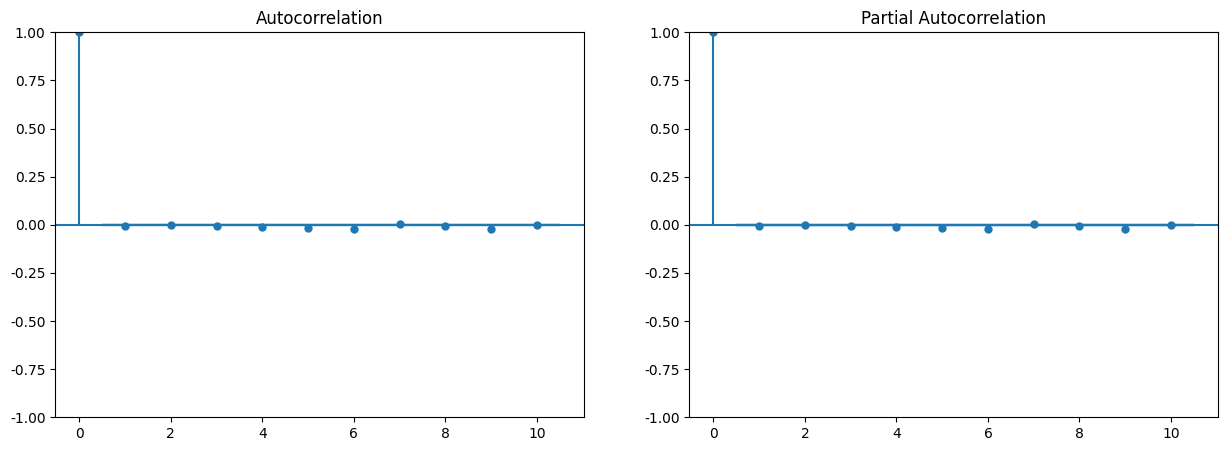

In [70]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig,ax = plt.subplots(1,2,figsize=(15,5))

plot_acf(df['price'].diff(1).dropna(), ax=ax[0], lags=10)
plot_pacf(df['price'].diff(1).dropna(), ax=ax[1], lags=10)
plt.show()

## 0이 아닌 마지막 래그는 0임으로 p=0. q =0 으로 선정

In [71]:
from statsmodels.graphics.tsaplots import plot_predict

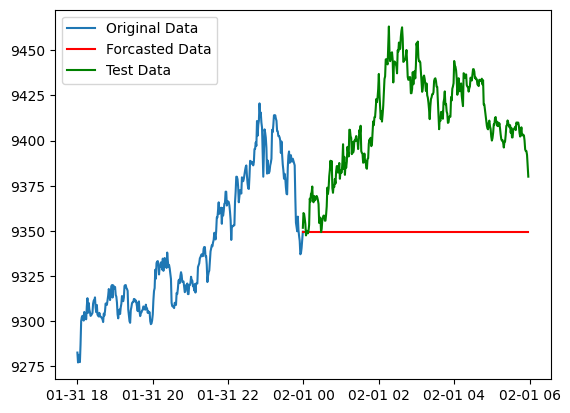

4405.241477777814

In [87]:
train = df[df['date'].dt.month == 1].reset_index(drop = True).set_index('date')['price']
test = df[df['date'].dt.month == 2].reset_index(drop = True).set_index('date')['price']

# Datetimeindex
train.index = pd.DatetimeIndex(train.index).to_period('T')
test.index= pd.DatetimeIndex(test.index).to_period('T')

# ARIMA Model
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train, order = (0,1,0), freq = 'T')
model_fit = model.fit()
fcst = model_fit.forecast(steps = 360)

plt.plot(train.tail(360).to_timestamp(), label = 'Original Data')
for_index = pd.date_range(start = train.index[-1].to_timestamp(), periods = 360, freq = 'T')

plt.plot(for_index, fcst, color = 'red', label = 'Forcasted Data')
plt.plot(for_index, test.values, color = 'green', label = 'Test Data')
plt.legend()
plt.show()

# 평가
from sklearn.metrics import mean_squared_error
mean_squared_error(test.values, fcst.values)

In [ ]:
#dataurl = https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/mock/001_s2.csv 위 데이터는 영화관 이용객의 장르별 팝콘 구매여부에 관한 데이터이다.
#장르별 팝콘 구매 여부가 연관이 있는지 확인하고 싶다.
#(1) 가설설정, 가설 검증
#(2) 장르과 구매여부의 정량적인 상관정도를 구하고 분석하라

In [101]:
import pandas as pd
df =pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/mock/001_s2.csv')

cols = ['장르', '구매여부']

# 장르 4개 / 구매 여부 : 2
for col in cols :
   t= df[col].value_counts()
   print(t)

from scipy.stats import chi2_contingency
chi2, p, dof, expected = chi2_contingency(pd.crosstab(df['장르'], df['구매여부']))

cross = pd.crosstab(df['장르'], df['구매여부'])

## 크라메르 연관계수 - 빈도표를 데이터로 사용
n = np.sum(cross).sum()  # 총 관측치 수
min_dim = min(cross.shape) - 1
V = np.sqrt((chi2/n) // min_dim)

장르
코미디    300
액션     125
가족     120
공포      55
Name: count, dtype: int64
구매여부
구매     310
미구매    290
Name: count, dtype: int64


어느 도시에서 성인 전체의 25%가 흡연자라고 한다. 만약 현재도 이와 비슷한 비율이 유지된다면 1300명의 성인표본에서 흡연자가 317명보다 작을 확률은

In [103]:
from scipy.stats import norm
p = 0.25
n = 1300
x = 317

sigma = (p * (1 - p) / n ) ** 0.5
p_x = x / n

norm.cdf(p_x, p , sigma)

0.30418201463044886

어떤 앱 개발 회사가 새로운 게임을 출시했다. 사용자가 게임 내에서 특정 퀘스트를 클리어하는 성공 확률이 0.3이라고 한다. </br>
(1) 사용자가 총 3회의 성공을 하기까지 시도한 횟수가 5회 미만일 확률은 얼마인가?</br>
(2) 사용자가 4번의 퀘스트 클리어 성공을 경험하기까지 평균적으로 몇 번의 시도를 하는가?

In [107]:
from scipy.stats import nbinom
p = 0.3

# (1) P(X<5) = P(X=3) + P(X= 4)
n = 3
prob1 = nbinom.cdf(1, n, p )
print(prob1)


# (2) E(X) = r/p

4 / p

0.0837


13.333333333333334

데이터는 년도별 플로리다에서 발생한 상어 공격 횟수와 해당 연도의 인구수이다. 일반화선형모형을 이용하여 년도별 인구에 따른 상어공격 수에 대한 모델링을 진행하라 (포아송 분포를 고려하여 모델링을 하고 오프셋은 인구를 1000으로 나눈 후 로그를 씌운값으로 진행하라.) </br>
(1) 모델링 후 모델에 대한 분석을 진행하라.(시각화포함) </br>
(2) 2000년도에 인구가 16224544라고 할 때 상어 공격횟수를 예측한 값을 출력하라

In [115]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/mock/001_s5.csv')


df['offset'] = np.log(df['Population'] / 1000)
x = df[['Year', 'offset']]
y = df['Attacks']

# 포아송 회귀
import statsmodels.api as sm
x = sm.add_constant(x)
mdoel = sm.GLM(y, x, family  = sm.families.Poisson())
fitted = model.fit()
display(fitted.summary())


# (2) 예측
a =np.log(16224544/1000)
test = np.array([1, 2000, a])
pred = fitted.predict(test)
print(pred)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  price   No. Observations:                44640
Model:                 ARIMA(0, 1, 0)   Log Likelihood             -148043.793
Date:                Mon, 29 Jul 2024   AIC                         296089.587
Time:                        13:38:34   BIC                         296098.293
Sample:                    01-01-2020   HQIC                        296092.328
                         - 01-31-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        44.4798      0.056    799.830      0.000      44.371      44.589
===================================================================================
Ljung-Box (L1) (Q):                   1.98   Jarque-Bera (JB):           5709775.54
Prob(Q):                              0.16   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -1.13
Prob(H) (two-sided):                  0.00   Kurtosis:                        58.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

ValueError: Value must be Period, string, integer, or datetime